# Oscilador Harmônico Quântico

## Bibliotecas utilizadas

In [1]:
# python standard
import time

# third-party
import numpy as np
import scipy.constants as cte
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import gaussian
from scipy.special import factorial, hermite, legendre
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

## Configurações Gráficas

In [4]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

## Constantes físicas

In [5]:
 # grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
hbar_si = cte.value('Planck constant over 2 pi')
me = cte.value('electron mass')
au2ang = au_l / 1e-10
au2ev = au_e / ev

## Potencial

In [6]:
def omega(wave_length):
    """
    Para um dado comprimento de onda [wave_length] em metros, retorna a
    frequência angular em rad/sec

    Parâmetros
    ----------
    wave_length : float
        o comprimento de onda em metros

    Retorna
    -------
    ang_freq : tuple
        frequência angular (ang_freq_si, ang_freq_au)
    """
    f = c / wave_length # Hz
    w = 2.0 * np.pi * f
    return w, w * au_t


def potencial_au(wave_length, L, N):
    """
    Para um [wave_length] (contido em um espaço de tamanho [L] e
    representado por [N] pontos), esta função retorna o potencial do
    oscilador harmônico quântico associado. A origem é posicionada no
    meio do potencial [-L/2,+L/2].

    Parâmetros
    ----------
    wave_length : float
        o comprimento de onda em metros
    L : float
        o tamanho do sistema em Angstrom
    N : int
        o número de pontos no espaço

    Retorna
    -------
    potencial : tuple
        (z_si, z_au, v_ev, v_si, v_au) onde:
            - [z_si] é a malha espacial (SI)
            - [z_au] é a malha espacial (AU)
            - [v_si] é o potencial (SI)
            - [v_ev] é o potencial (eV)
            - [v_au] é o potencial (AU)
    """
    w, _ = omega(wave_length)
    z_si = np.linspace(-(L/2) * 1e-10, (L/2) * 1e-10, N)
    z_au = np.linspace(-L/au2ang/2.0, L/au2ang/2.0, N)
    v_si = 0.5 * me * z_si**2 * w**2 # potential in Joules
    v_ev = v_si / ev # Joules to eV
    v_au = v_ev / au2ev # eV to au
    return z_si, z_au, v_ev, v_si, v_au

# Solução analítica

In [7]:
def solucao_analitica(L=100.0, N=2048, wave_length=8.1e-6, nmax=6):
    """
    Esta função calcula analiticamente os primeiros [nmax] autovalores
    e autofunções para um oscilador harmônico quântico com frequência
    angular correspondente a um comprimento de onda [wave_length].

    Parâmetros
    ----------
    L : float
        tamanho do sistema em Angstrom
    N : int
        numero de pontos
    wave_length : float
        comprimento de onda em metros
    nmax : int
        numero de autoestados e autofunções a serem calculados
    
    Retorna
    -------
    result : dictionary
        Um dicionário com as seguintes chaves:
        - `z_si` malha espacial (SI)
        - `z_au` malha espacial (AU)
        - `v_au` potencial (AU)
        - `v_ev` potencial (eV)
        - `v_si` potencial (SI)
        - `eigenvalues_si` autovalores (Joules)
        - `eigenvalues_ev` autovalores (eV)
        - `eigenvalues_au` autovalores (AU)
        - `eigenstates_au` autofunções (AU)
        - `eigenstates_2_au` autofunções na forma |psi|^2 (AU)
        - `eigenstates_si` autofunções (SI)
        - `eigenstates_2_si` autofunções na forma |psi|^2 (SI)
    """
    assert L > 0 # comprimento deve ser maior que zero
    assert wave_length > 0 # comprimento de onda deve ser maior que zero
    assert nmax > 0 # deve calcular ao menos um autovalor/autofunção
    assert int(np.log2(N)) == np.log2(N) # deve ser potencia de 2

    # malha espacial
    z_si, z_au, v_ev, v_si, v_au = potencial_au(wave_length, L, N)
    w, w_au = omega(wave_length)

    # nmax autovalores
    eigenvalues_si = [hbar_si * w * (n+1/2) for n in range(nmax)]
    eigenvalues_si = np.array(eigenvalues_si)
    eigenvalues_ev = eigenvalues_si / ev

    # nmax autoestados
    eigenstates_si = []
    eigenstates_au = []
    mwoh_au = w_au # m * w / hbar em AU
    mwoh_si = me * w / hbar_si # m * w / hbar em unidades do si
    for n in range(nmax):
        an_au = np.sqrt(1.0/(2.0**n * factorial(n))) * \
            (mwoh_au/np.pi)**(1.0/4.0)
        psin_au = an_au*np.exp(-mwoh_au*z_au**2/2.0) * \
            hermite(n)(np.sqrt(mwoh_au)*z_au)
        eigenstates_au.append(psin_au)

        an_si = np.sqrt(1.0/(2.0**n * factorial(n))) * \
            (mwoh_si/np.pi)**(1.0/4.0)
        psin_si = an_si*np.exp(-mwoh_si*z_si**2/2.0) * \
            hermite(n)(np.sqrt(mwoh_si)*z_si)
        eigenstates_si.append(psin_si)

    return {
        'z_si': z_si,
        'z_au': z_au,
        'v_au': v_au,
        'v_ev': v_ev,
        'v_si': v_si,
        'eigenvalues_si': eigenvalues_si,
        'eigenvalues_ev': eigenvalues_ev,
        'eigenvalues_au': eigenvalues_ev / au2ev,
        'eigenstates_au': eigenstates_au,
        'eigenstates_2_au': np.abs(eigenstates_au)**2,
        'eigenstates_si': eigenstates_si,
        'eigenstates_2_si': np.abs(eigenstates_si)**2,
    }

# Solução numérica

In [8]:
def solucao_numerica(L=100.0, N=2048, dt=1e-19, wave_length=8.1e-6,
                     nmax=6, precision=1e-2, iterations=None,
                     max_time=None, eigenstates_au=None, method='pe'):
    """
    Esta função calcula numericamente os primeiros [nmax] autovalores e
    autofunções para um oscilador harmônico quântico com frequência
    angular correspondente a um comprimento de onda [wave_length].

    Parameters
    ----------
    L : float
        tamanho do sistema em Angstrom
    N : int
        numero de pontos
    wave_length : float
        comprimento de onda em metros
    nmax : int
        numero de autoestados e autofunções a serem calculados
    dt : float
        o passo de tempo em segundos
    precision : float
        a convergência mínima no autovalor
    iterations : int
        o número máximo de iterações
    max_time : float
        o tempo máximo de processamento
    eigenstates_au : array_like
        um array com os chutes iniciais
    method : string
        o método pode ser:
            - 'pe' para Pseudo-Espectral
            - 'ii' para Interação Inversa
    
    Returns
    -------
    result : dictionary
        Um dicionário com as seguintes chaves:
        - `z_si` malha espacial (SI)
        - `z_au` malha espacial (AU)
        - `v_au` potencial (AU)
        - `v_ev` potencial (eV)
        - `v_si` potencial (SI)
        - `eigenvalues_si` autovalores (Joules)
        - `eigenvalues_ev` autovalores (eV)
        - `eigenvalues_au` autovalores (AU)
        - `eigenstates_au` autofunções (AU)
        - `eigenstates_2_au` autofunções na forma |psi|^2 (AU)
        - `eigenstates_si` autofunções (SI)
        - `eigenstates_2_si` autofunções na forma |psi|^2 (SI)
        - `iterations` um array com o número de iterações por autovalor
        - `timers` um array com o tempo de processamento por autovalor
        - `precisions` um array com a precisão por autovalor
        - `chebyshev` distânca de chebyshev por autofunção
        - `seuclidean` distânca euclidiana por autofunção
        - `sqeuclidean` distânca quadrada euclidiana por autofunção
    """
    assert L > 0 # comprimento deve ser maior que zero
    assert wave_length > 0 # comprimento de onda deve ser maior que zero
    assert nmax > 0 # deve calcular ao menos um autovalor/autofunção
    assert int(np.log2(N)) == np.log2(N) # deve ser potencia de 2

    # soluções analíticas
    analytical = solucao_analitica(L=L, N=N, wave_length=wave_length,
                                   nmax=nmax)
    eigenvalues_ev_ana = analytical['eigenvalues_ev']
    eigenstates_au_ana = analytical['eigenstates_au']

    # grid values
    z_si, z_au, v_ev, v_si, v_au = potencial_au(wave_length, L, N)
    dt_au = -1j * dt / au_t
    precision /= 100 # it is a percentage
    
    forecast = eigenvalues_ev_ana.copy() / au2ev #np.linspace(np.min(v_au), np.max(v_au), 40)
    dz2 = (z_au[1]-z_au[0])**2

    # split step
    dz_au = np.abs(z_au[1] - z_au[0])
    k_au = fftfreq(N, d=dz_au)
    exp_v2 = np.exp(- 0.5j * v_au * dt_au)
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au)
    evolution_operator = lambda p: exp_v2*ifft(exp_t*fft(exp_v2*p))
    
    # chutes iniciais
    if not eigenstates_au:
        short_grid = np.linspace(-1, 1, N)
        g = gaussian(N, std=int(N/100))
        eigenstates_au = np.array([g*legendre(i)(short_grid) \
            for i in range(nmax)],dtype=np.complex_)
        eigenvalues_ev = np.zeros(nmax)
    counters = np.zeros(nmax)
    timers = np.zeros(nmax)
    precisions = np.zeros(nmax)
    vectors_chebyshev = np.zeros(nmax)
    vectors_sqeuclidean = np.zeros(nmax)
    vectors_seuclidean = np.zeros(nmax)

    # matrix diagonals
    sub_diag = -(0.5 / dz2) * np.ones(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    def get_invA(v_shift=0.0):
        "aplica um deslocamento no potencial, o mesmo que H'=H-shift "
        main_diag = (v_au-v_shift+1.0/dz2)
        diagonals = [main_diag, sub_diag, sub_diag]
        return inv(diags(diagonals, [0, -1, 1]).toarray())
    
    if method == 'pe':
        for s in range(nmax):
            while True:
                start_time = time.time()
                eigenstates_au[s] = evolution_operator(eigenstates_au[s])
                counters[s] += 1

                # gram-shimdt
                for m in range(s):
                    proj = simps(eigenstates_au[s] * \
                        np.conjugate(eigenstates_au[m]), z_au)
                    eigenstates_au[s] -= proj * eigenstates_au[m]

                # normalize
                A = np.sqrt(simps(np.abs(eigenstates_au[s])**2, z_au))
                eigenstates_au[s] /= A
                timers[s] += time.time() - start_time

                if (iterations and counters[s] >= iterations) \
                    or (max_time and timers[s] >= max_time) \
                    or counters[s] % 1000 == 0:
                    # second derivative
                    derivative2 = (eigenstates_au[s][:-2] - 2 * \
                        eigenstates_au[s][1:-1] + \
                        eigenstates_au[s][2:]) / dz_au**2
                    psi = eigenstates_au[s][1:-1]
                    # <Psi|H|Psi>
                    p_h_p = simps(psi.conj() * (-0.5 * derivative2 + \
                        v_au[1:-1] * psi), z_au[1:-1])
                    # divide por <Psi|Psi> 
                    p_h_p /= A**2
                    eigenvalues_ev[s] = p_h_p.real * au2ev # eV

                    precisions[s] = np.abs(1-eigenvalues_ev[s] / eigenvalues_ev_ana[s])
                    
                    if (iterations and counters[s] >= iterations) \
                        or (max_time and timers[s] >= max_time) \
                        or (not iterations and not max_time \
                            and precisions[s] < precision):
                        XA = [eigenstates_au[s]]
                        XB = [eigenstates_au_ana[s]]
                        vectors_chebyshev[s] = \
                            cdist(XA, XB, 'chebyshev')[0][0]
                        vectors_seuclidean[s] = \
                            cdist(XA, XB, 'seuclidean')[0][0]
                        vectors_sqeuclidean[s] = \
                            cdist(XA, XB, 'sqeuclidean')[0][0]
                        break
    elif method == 'ii':
        for s in range(nmax):
            last_ev = 1.0
            last_es = np.zeros(N, dtype=np.complex_)
            
            shift     = forecast[s]
            invA      = get_invA(shift)
            V_shifted = v_au-shift
            
            while True:
                start_time = time.time()
                eigenstates_au[s] = invA.dot(eigenstates_au[s])
                counters[s] += 1
                
                # normalize
                A = np.sqrt(simps(eigenstates_au[s] *\
                                  eigenstates_au[s].conj(), z_au))
                eigenstates_au[s] /= A
                timers[s] += time.time() - start_time

                if (iterations and counters[s] >= iterations) \
                    or (max_time and timers[s] >= max_time) \
                    or counters[s] % 100 == 0:
                    # second derivative
                    derivative2 = (eigenstates_au[s][:-2] - 2 * \
                        eigenstates_au[s][1:-1] + \
                        eigenstates_au[s][2:]) / dz_au**2
                    psi = eigenstates_au[s][1:-1]
                    # <Psi|H|Psi>
                    p_h_p = simps(psi.conj() * (-0.5 * derivative2 + \
                        V_shifted[1:-1] * psi), z_au[1:-1])
                    # divide por <Psi|Psi> 
                    p_h_p /= A**2
                    eigenvalues_ev[s] = (p_h_p.real + shift) * au2ev # eV

                    # descobre se é repetido
                    eigenvalues = np.array([ev for ev in eigenvalues_ev if ev != 0.0])
                    eigenvalues = eigenvalues[eigenvalues.argsort()]
                    golden_ones = [0]
                    for i in range(eigenvalues.size):
                        # drop repeated and unbounded states
                        if i == 0 or np.abs(eigenvalues[i]/eigenvalues[i-1]-1) < 0.1 \
                            or eigenvalues[i] > np.max(v_ev):
                            continue
                        golden_ones.append(i)  
                    
                    if len(golden_ones) < len(eigenvalues):
                        forecast_diff = forecast[-1] - forecast[-2]
                        forecast_max = max(forecast)
                        forecast.pop(s)
                        forecast.append(forecast_max + forecast_diff)
                        s -= 1
                        break
                    precisions[s] = np.abs(1-eigenvalues_ev[s] / eigenvalues_ev_ana[s])    
                    
                    if (iterations and counters[s] >= iterations) \
                        or (max_time and timers[s] >= max_time) \
                        or (not iterations and not max_time \
                            and precisions[s] < precision):
                        XA = [eigenstates_au[s]]
                        XB = [eigenstates_au_ana[s]]
                        vectors_chebyshev[s] = \
                            cdist(XA, XB, 'chebyshev')[0][0]
                        vectors_seuclidean[s] = \
                            cdist(XA, XB, 'seuclidean')[0][0]
                        vectors_sqeuclidean[s] = \
                            cdist(XA, XB, 'sqeuclidean')[0][0]
                        break
        
    # gera autoestados no SI
    eigenstates_si = np.array([np.ones(N, dtype=np.complex_) \
        for i in range(nmax)],dtype=np.complex_)
    for i, state in enumerate(eigenstates_au):
        A_si = np.sqrt(simps(np.abs(state)**2, z_si))
        eigenstates_si[i] = state / A_si

    return {
        'z_si': z_si,
        'z_au': z_au,
        'v_au': v_au,
        'v_ev': v_ev,
        'v_si': v_si,
        'eigenvalues_si': eigenvalues_ev * ev,
        'eigenvalues_ev': eigenvalues_ev,
        'eigenvalues_au': eigenvalues_ev / au2ev,
        'eigenstates_au': eigenstates_au,
        'eigenstates_2_au': np.abs(eigenstates_au)**2,
        'eigenstates_si': eigenstates_si,
        'eigenstates_2_si': np.abs(eigenstates_si)**2,
        'iterations': counters,
        'timers': timers,
        'precisions': precisions,
        'chebyshev': vectors_chebyshev,
        'seuclidean': vectors_seuclidean,
        'sqeuclidean': vectors_sqeuclidean
    }

# Performance do método pseudo-espectral

In [ ]:
res_pe = {}
# aqui coletamos 
for max_iteracoes in [int(1e5 * i) for i in range(1,11)]:
    res_pe[max_iteracoes] = solucao_numerica(N=1024, nmax=6, method='pe',
                                             iterations=max_iteracoes)
np.save("saidas/oscilador_harmonico_metodo_pseudo_espectral.npy", res_pe)

In [9]:
res = np.load("saidas/oscilador_harmonico_metodo_pseudo_espectral.npy").item()
iteracoes = sorted(res.keys())
timers = np.array([res[it]['timers'] for it in iteracoes]).T
precisions = np.array([res[it]['sqeuclidean'] for it in iteracoes]).T

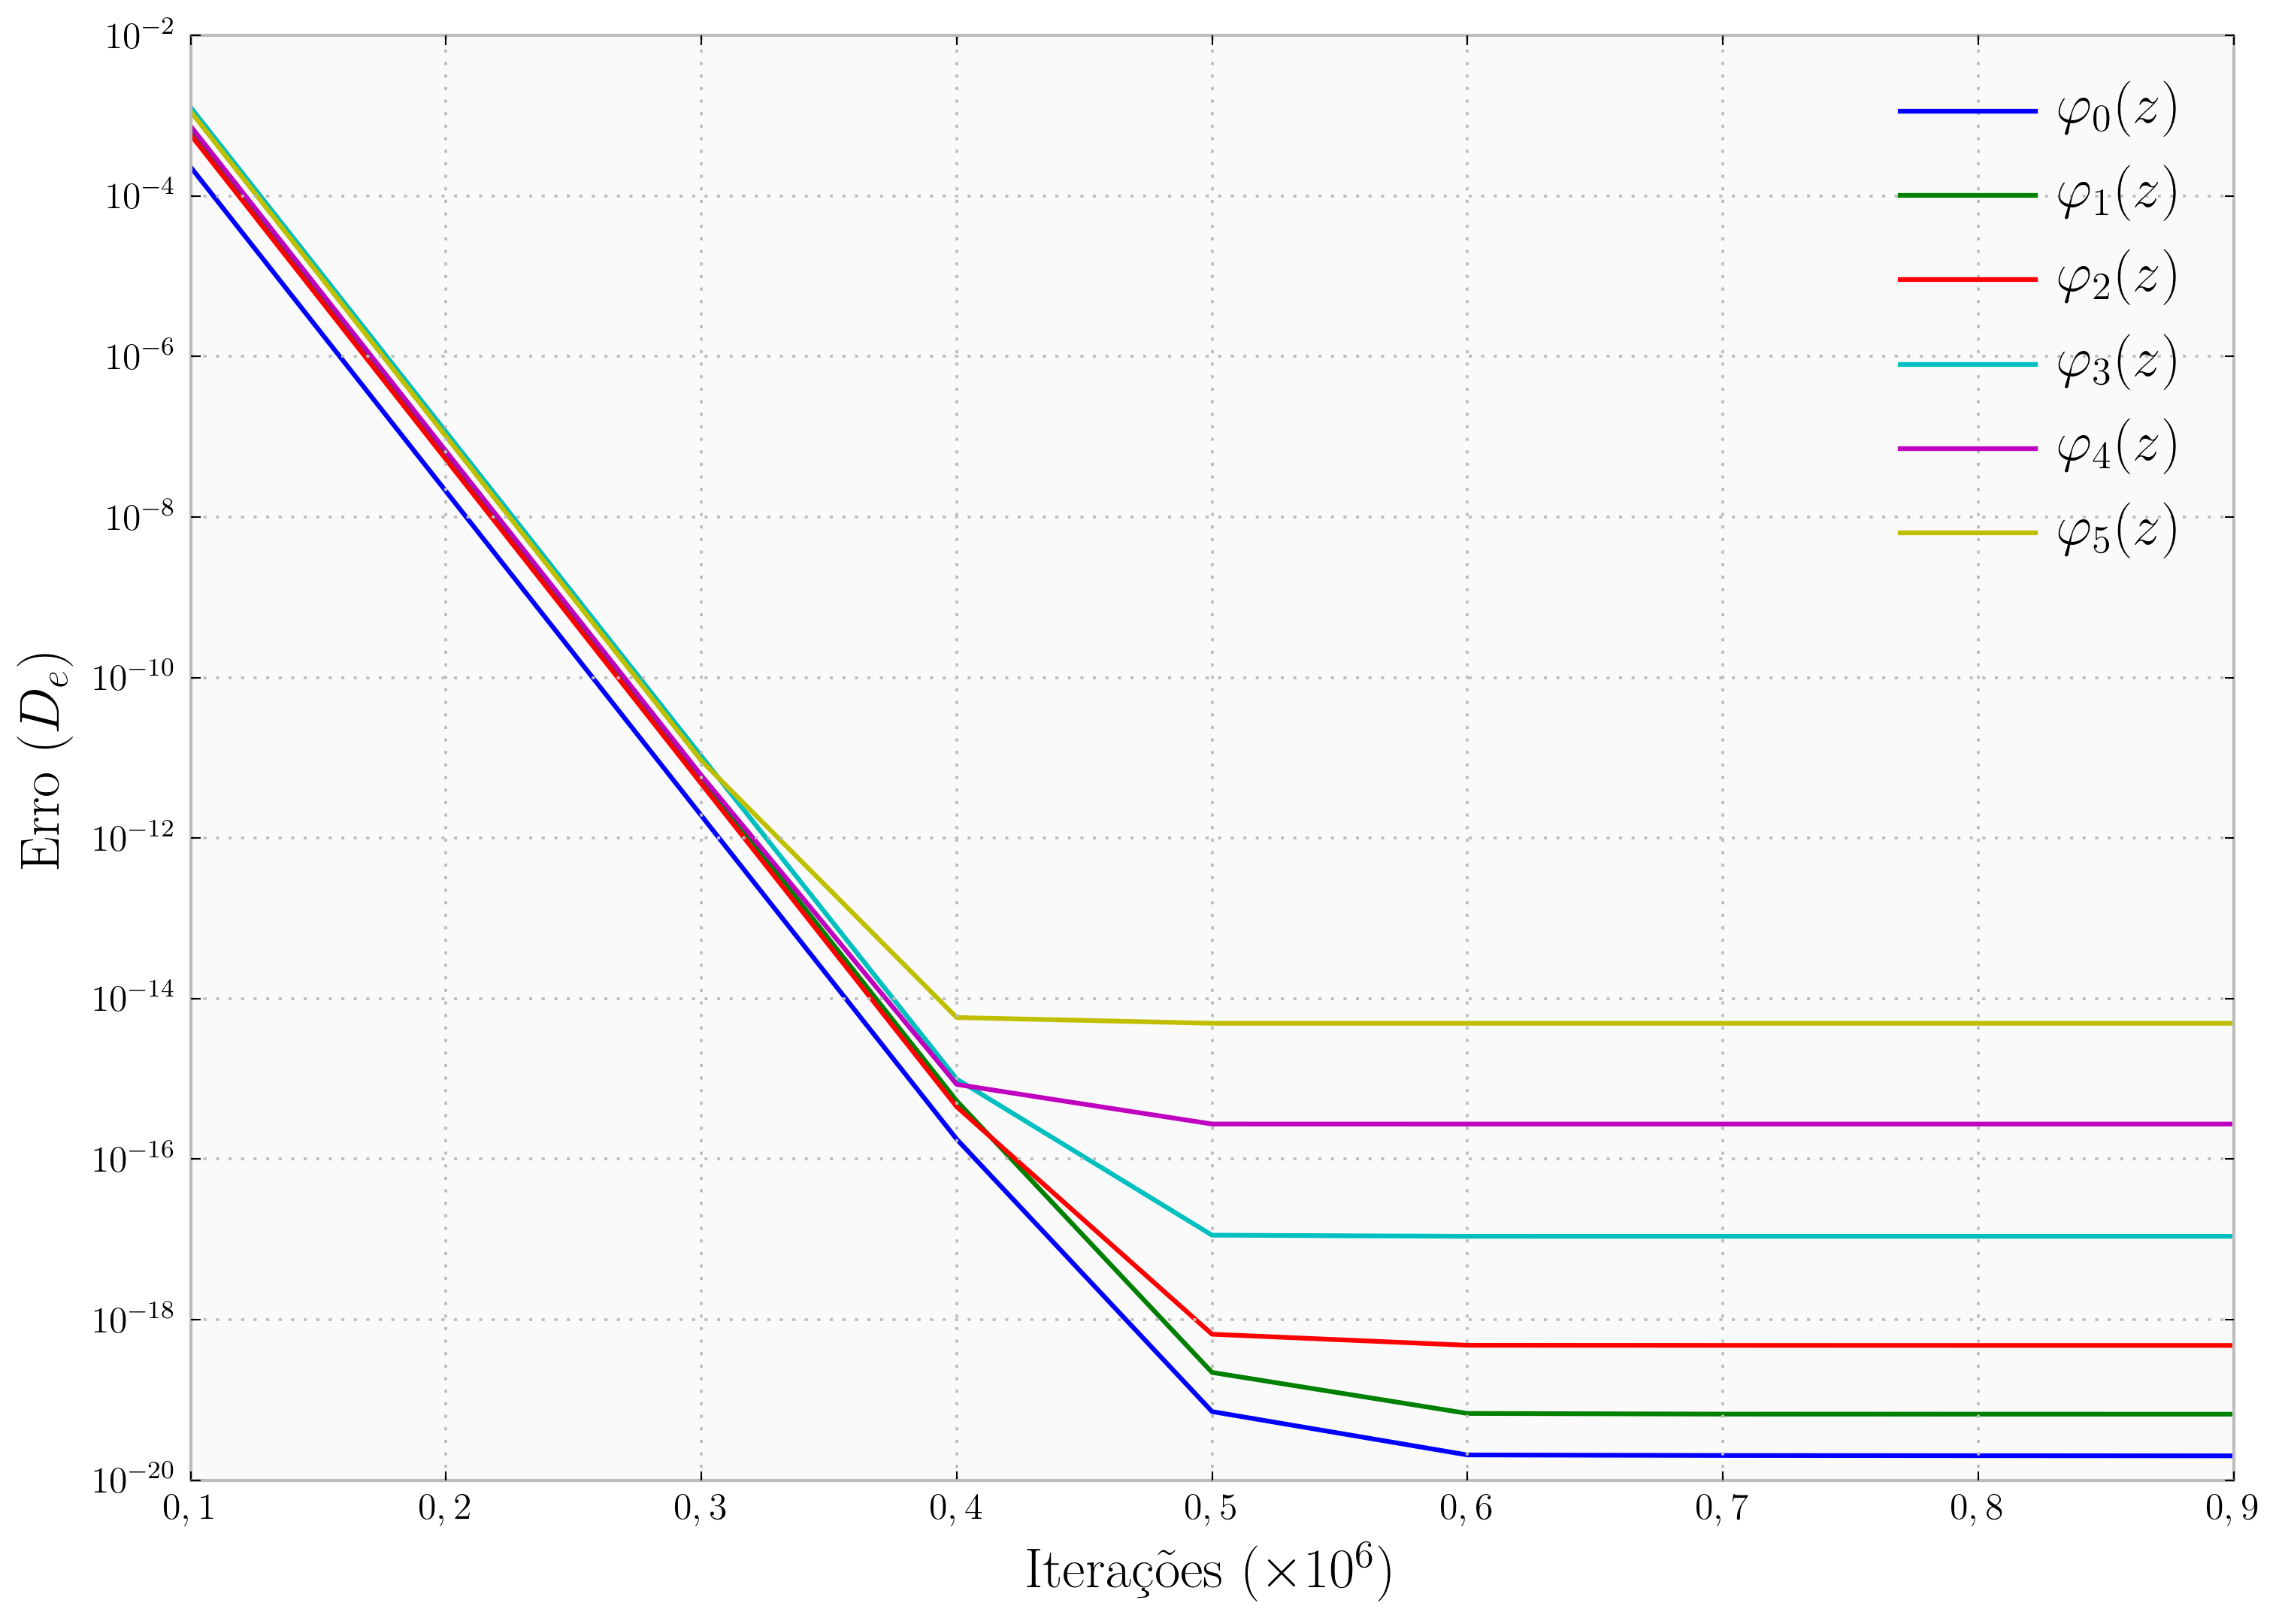

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Itera\c{c}\~{o}es ($\times 10^6$)')
ax.set_ylabel(r'Erro ($D_e$)')
for i, pres in enumerate(precisions):
    ax.semilogy(np.array(iteracoes)/1e6, pres, label=r'$\varphi_{} (z)$'.format(i))
plt.legend()
plt.savefig('figuras/oscilador_harmonico_erro_por_iteracoes.png')

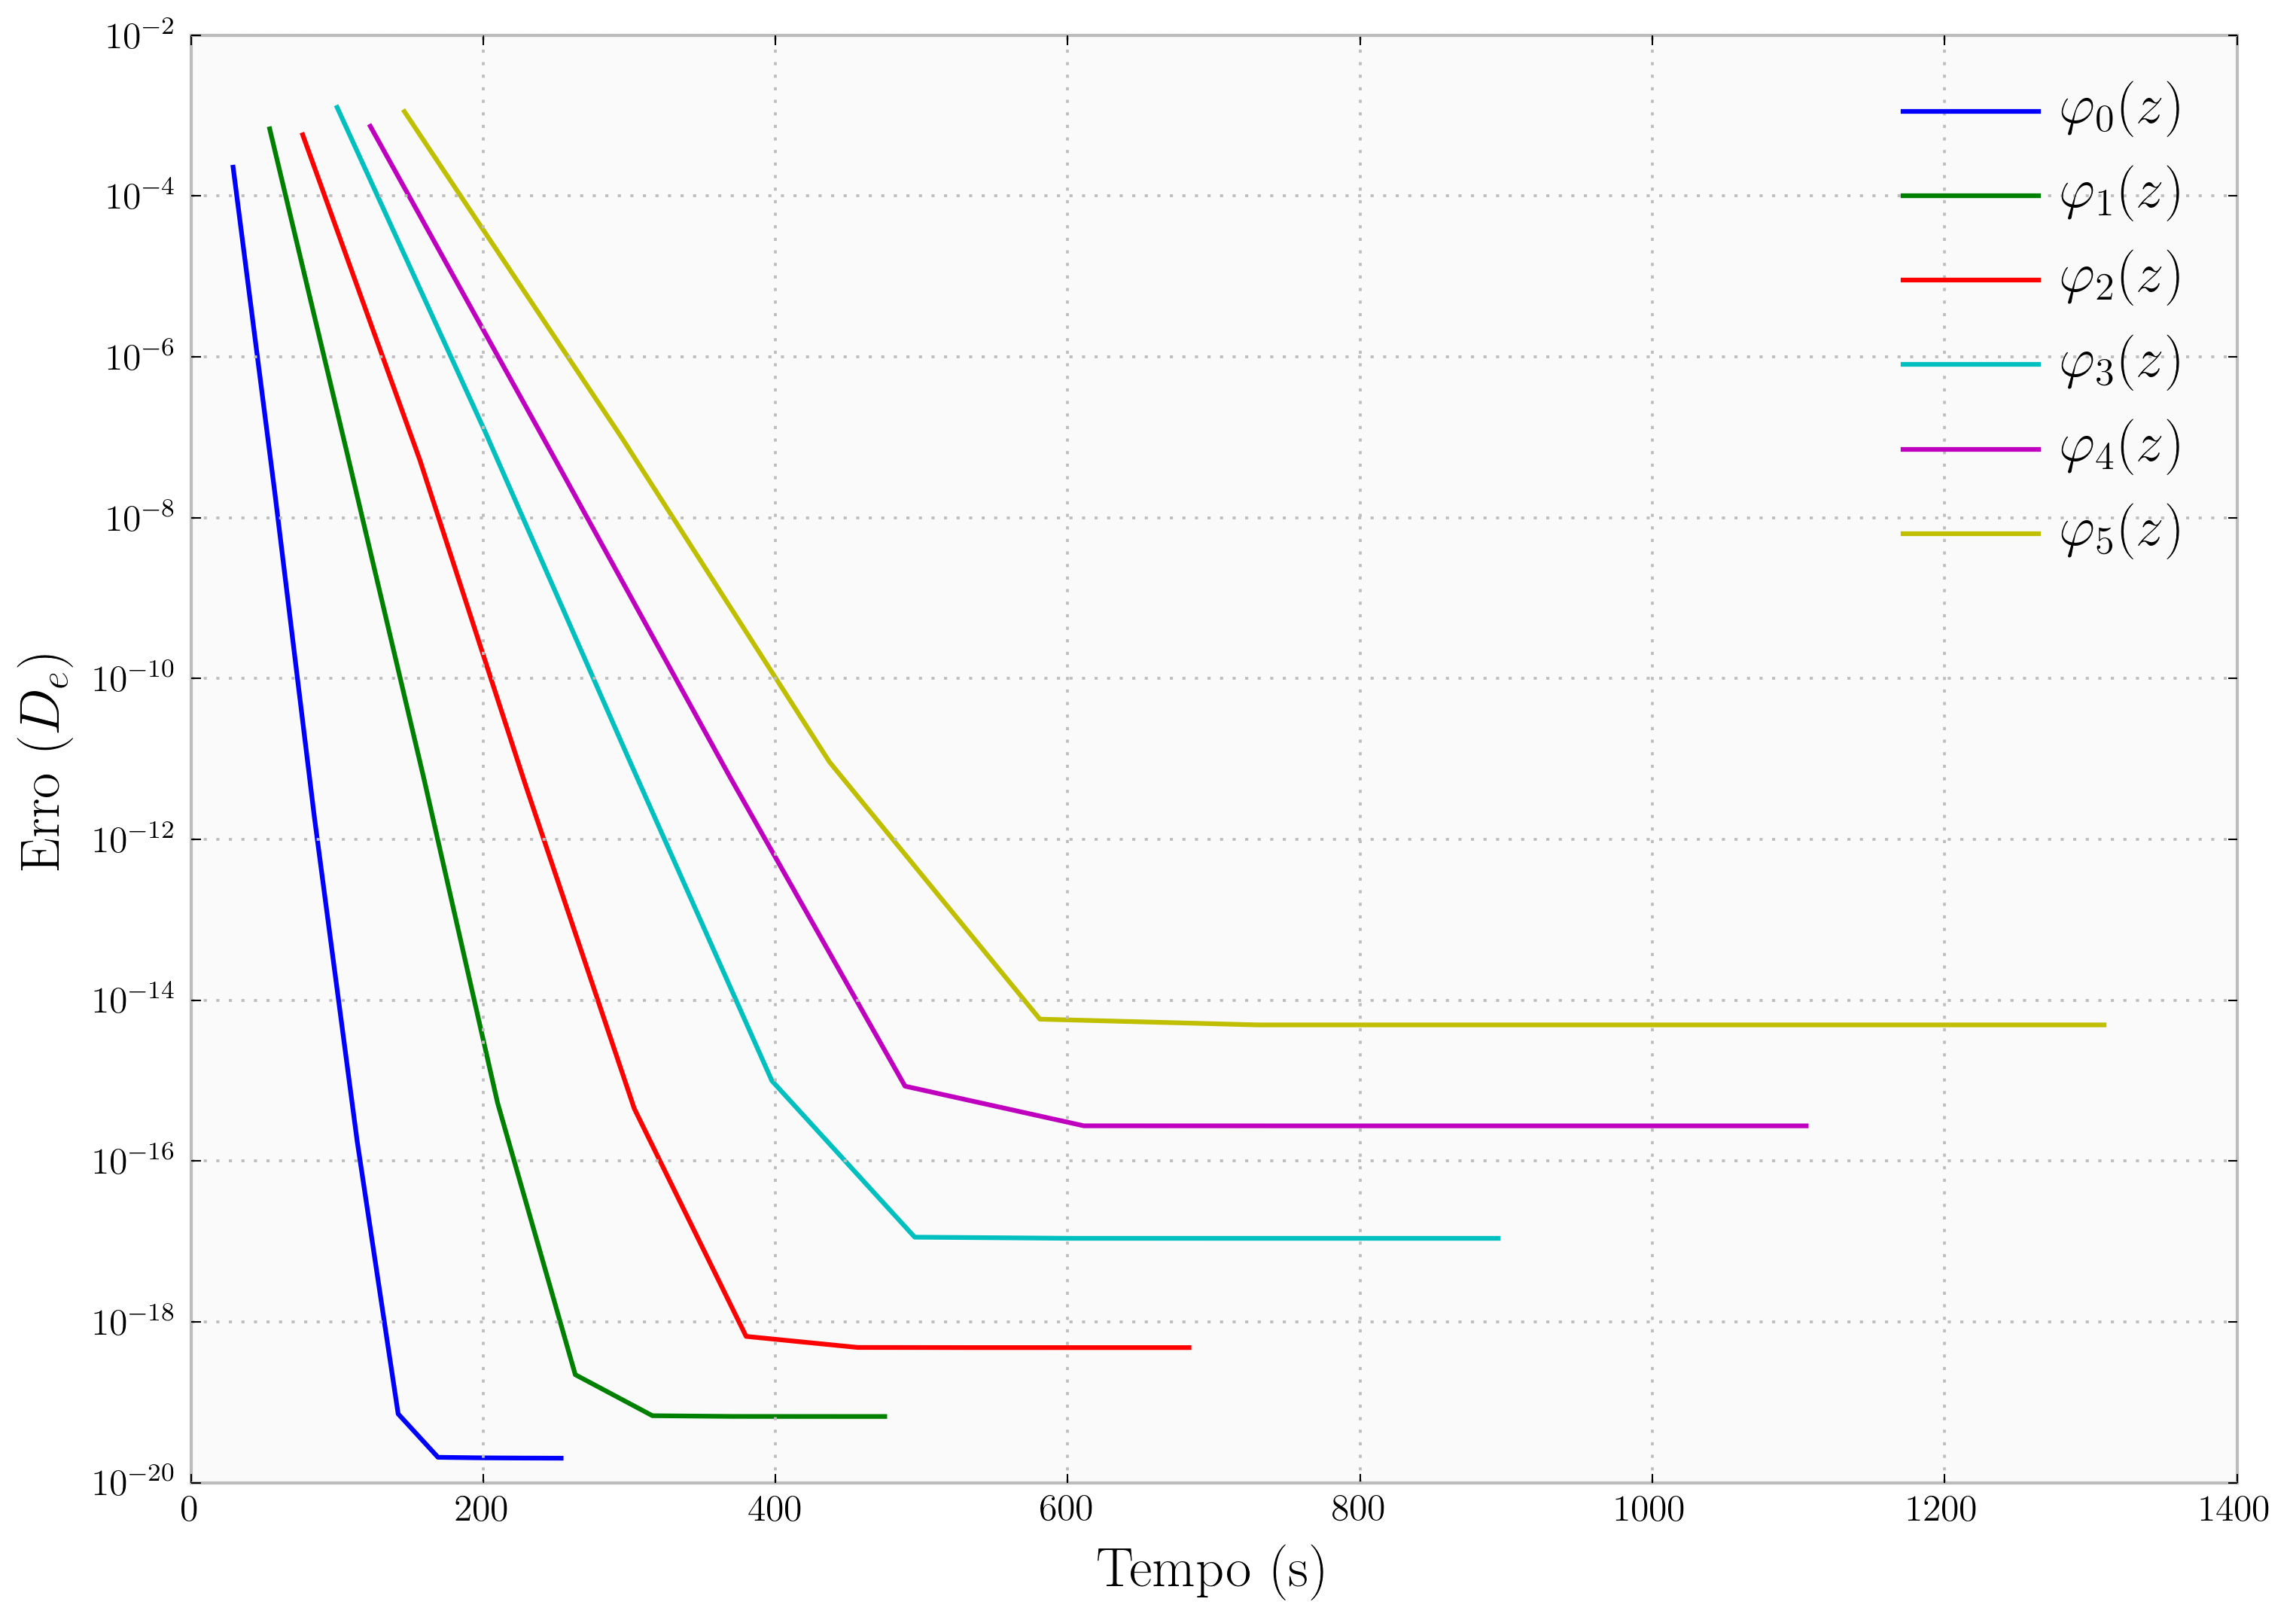

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Tempo (s)')
ax.set_ylabel(r'Erro ($D_e$)')
for i, pres in enumerate(precisions):
    ax.semilogy(timers[i], pres, label=r'$\varphi_{} (z)$'.format(i))
plt.legend()
plt.savefig('oscilador_harmonico_erro_por_tempo.png')

/home/euzi/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


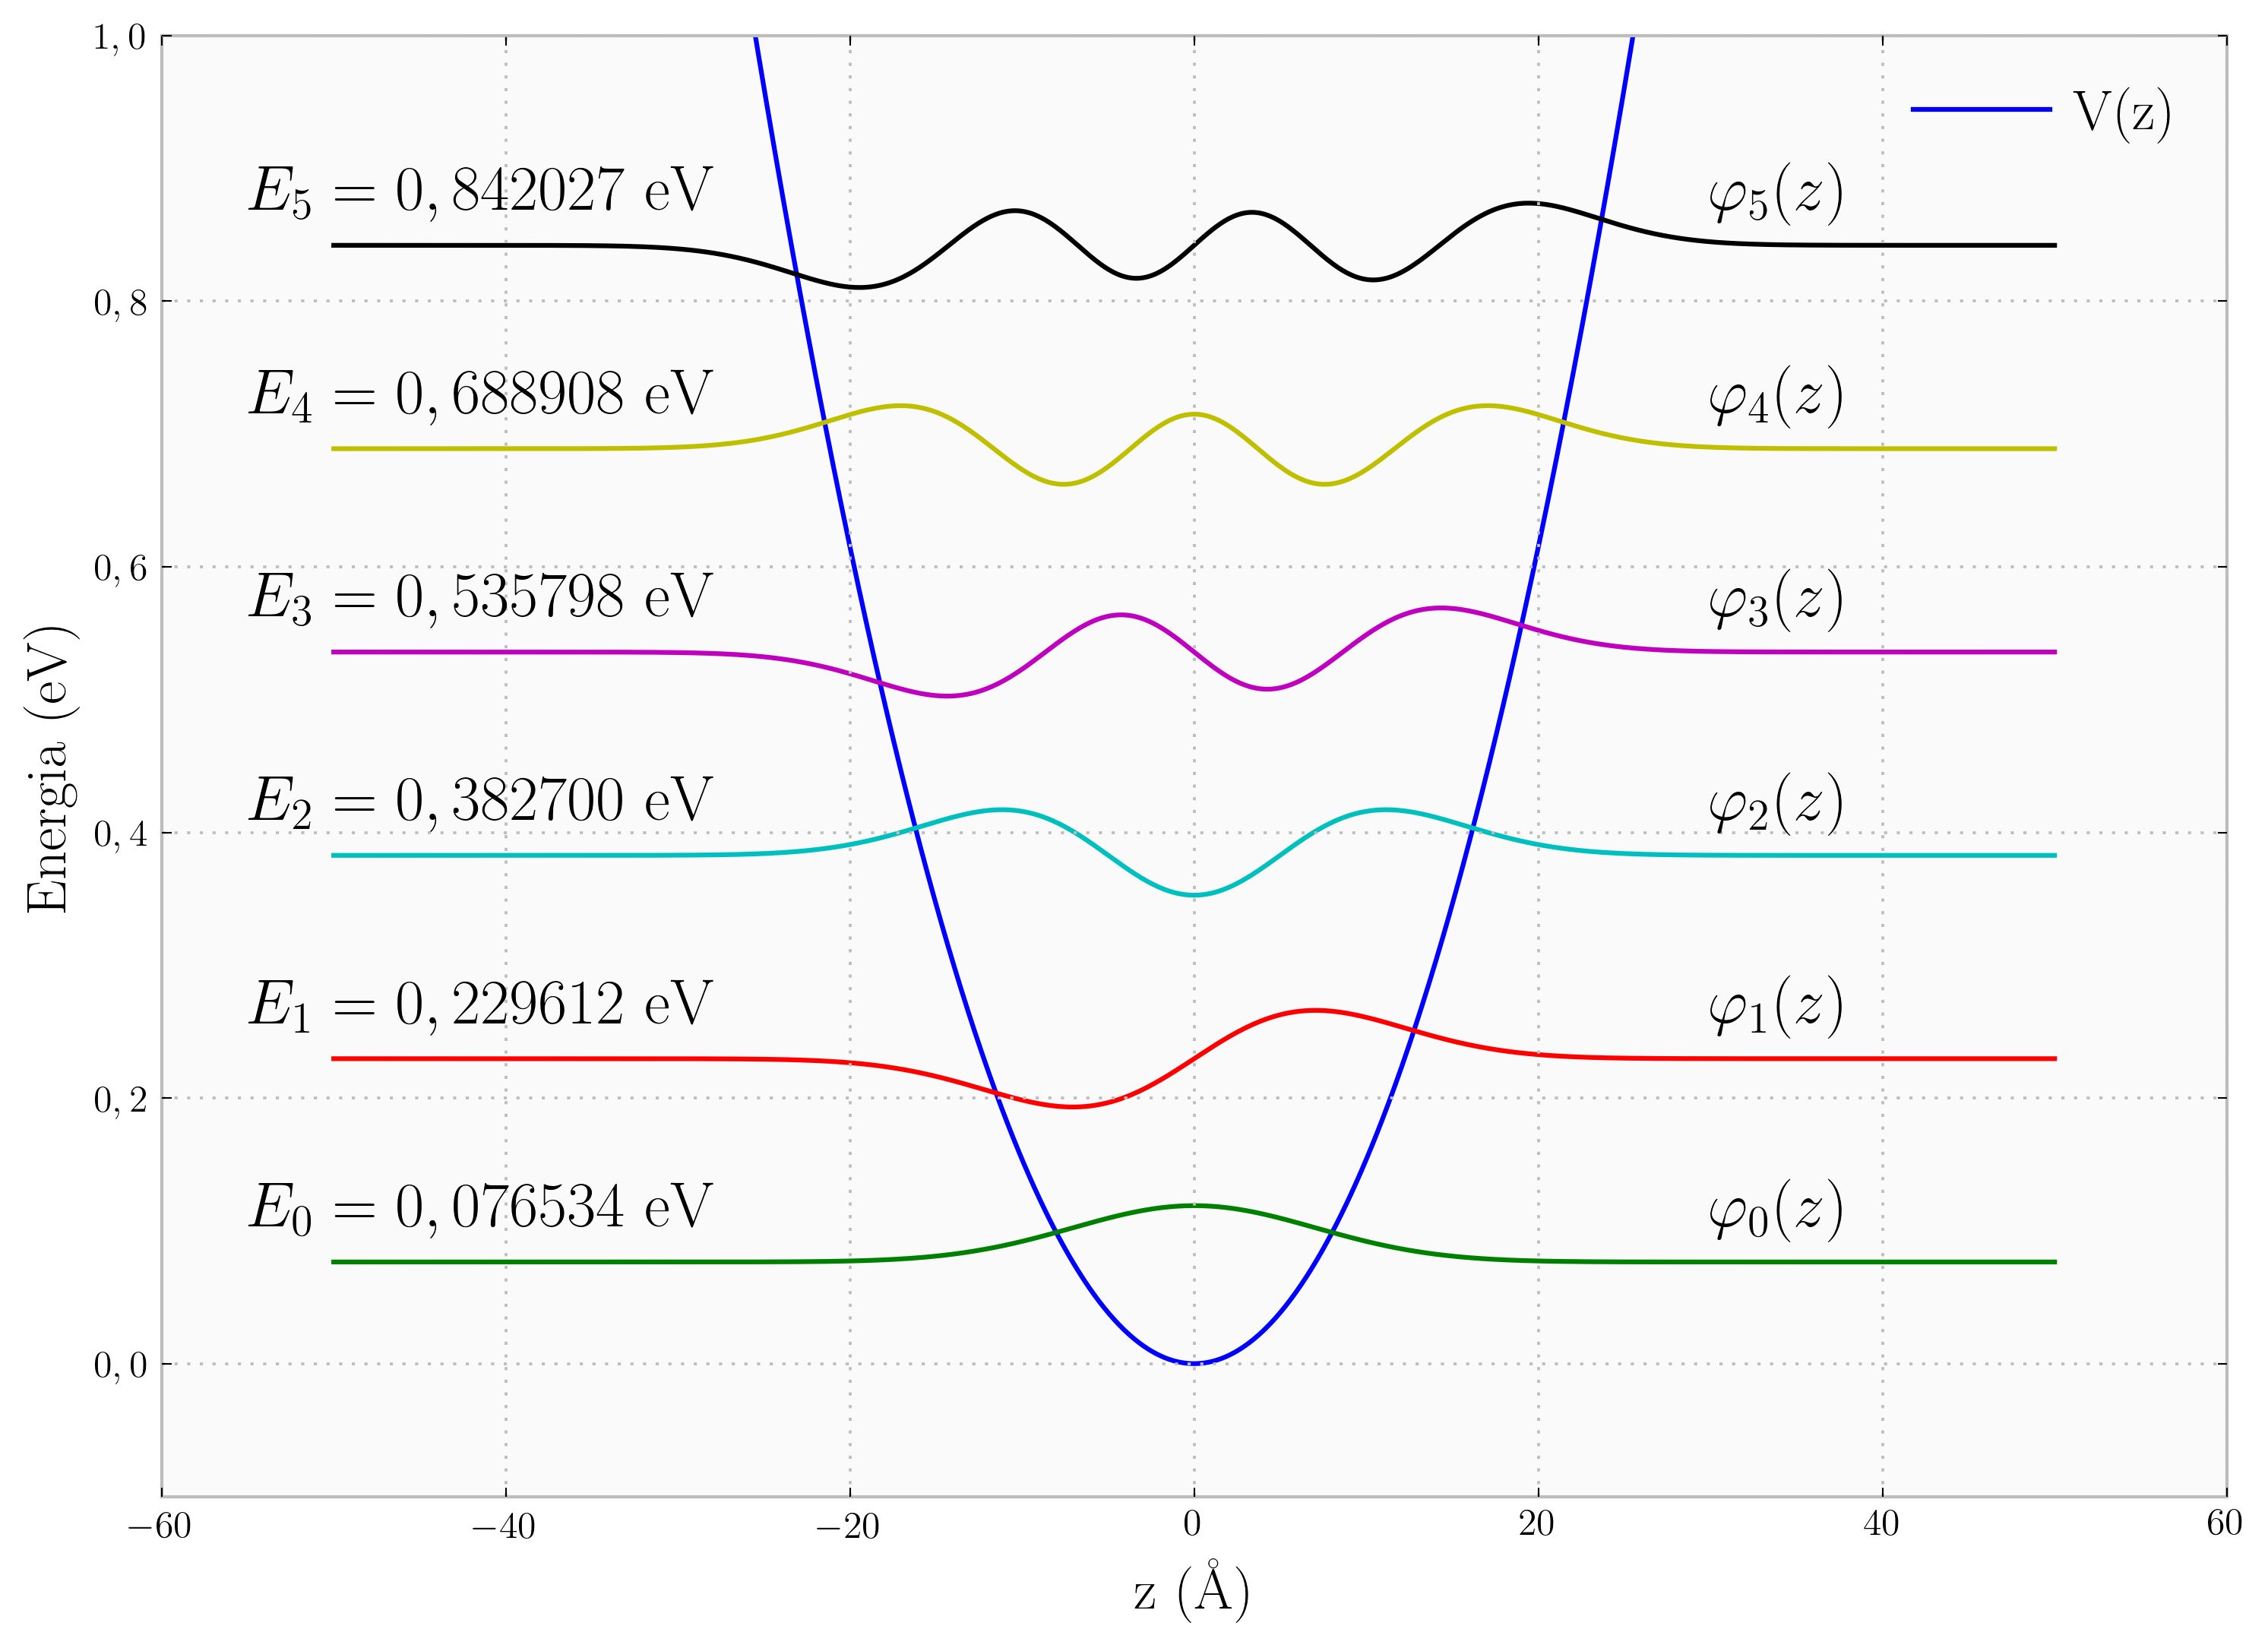

In [22]:
z_si, z_au, v_ev, v_si, v_au = potencial_au(8.1e-6, L=100.0, N=1024)
z_ang = z_au * au2ang
eigenstates_au = res[900000]['eigenstates_au']
eigenvalues_ev = res[900000]['eigenvalues_ev']
eigenstates_ang = eigenstates_au.copy()
for i, es in enumerate(eigenstates_au):
    norm_ang = np.sqrt(simps(es*es.conj(), z_ang))
    eigenstates_ang[i] = 0.15*(eigenstates_au[i]/norm_ang)+eigenvalues_ev[i]

fig, ax = plt.subplots()
ax.set_xlabel(r'z (\AA)')
ax.set_ylabel(r'Energia (eV)')

plt.ylim(-0.1, 1.0)
ax.plot(z_ang, v_ev, label='V(z)')
for i, es in enumerate(eigenstates_ang):
    ax.plot(z_ang, es)#, label=r'$\varphi_{} (z)$'.format(i))
    evlabel = (r'$E_{} = {:.6f}$ eV'.format(i, eigenvalues_ev[i]))
    evlabel = evlabel.replace('.', ',')
    ax.text(-55, eigenvalues_ev[i]+0.02, evlabel)
    ax.text(30, eigenvalues_ev[i]+0.02, r'$\varphi_{} (z)$'.format(i))
plt.legend()
plt.savefig('figuras/oscilador_harmonico_autovetores.png') 

/home/euzi/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


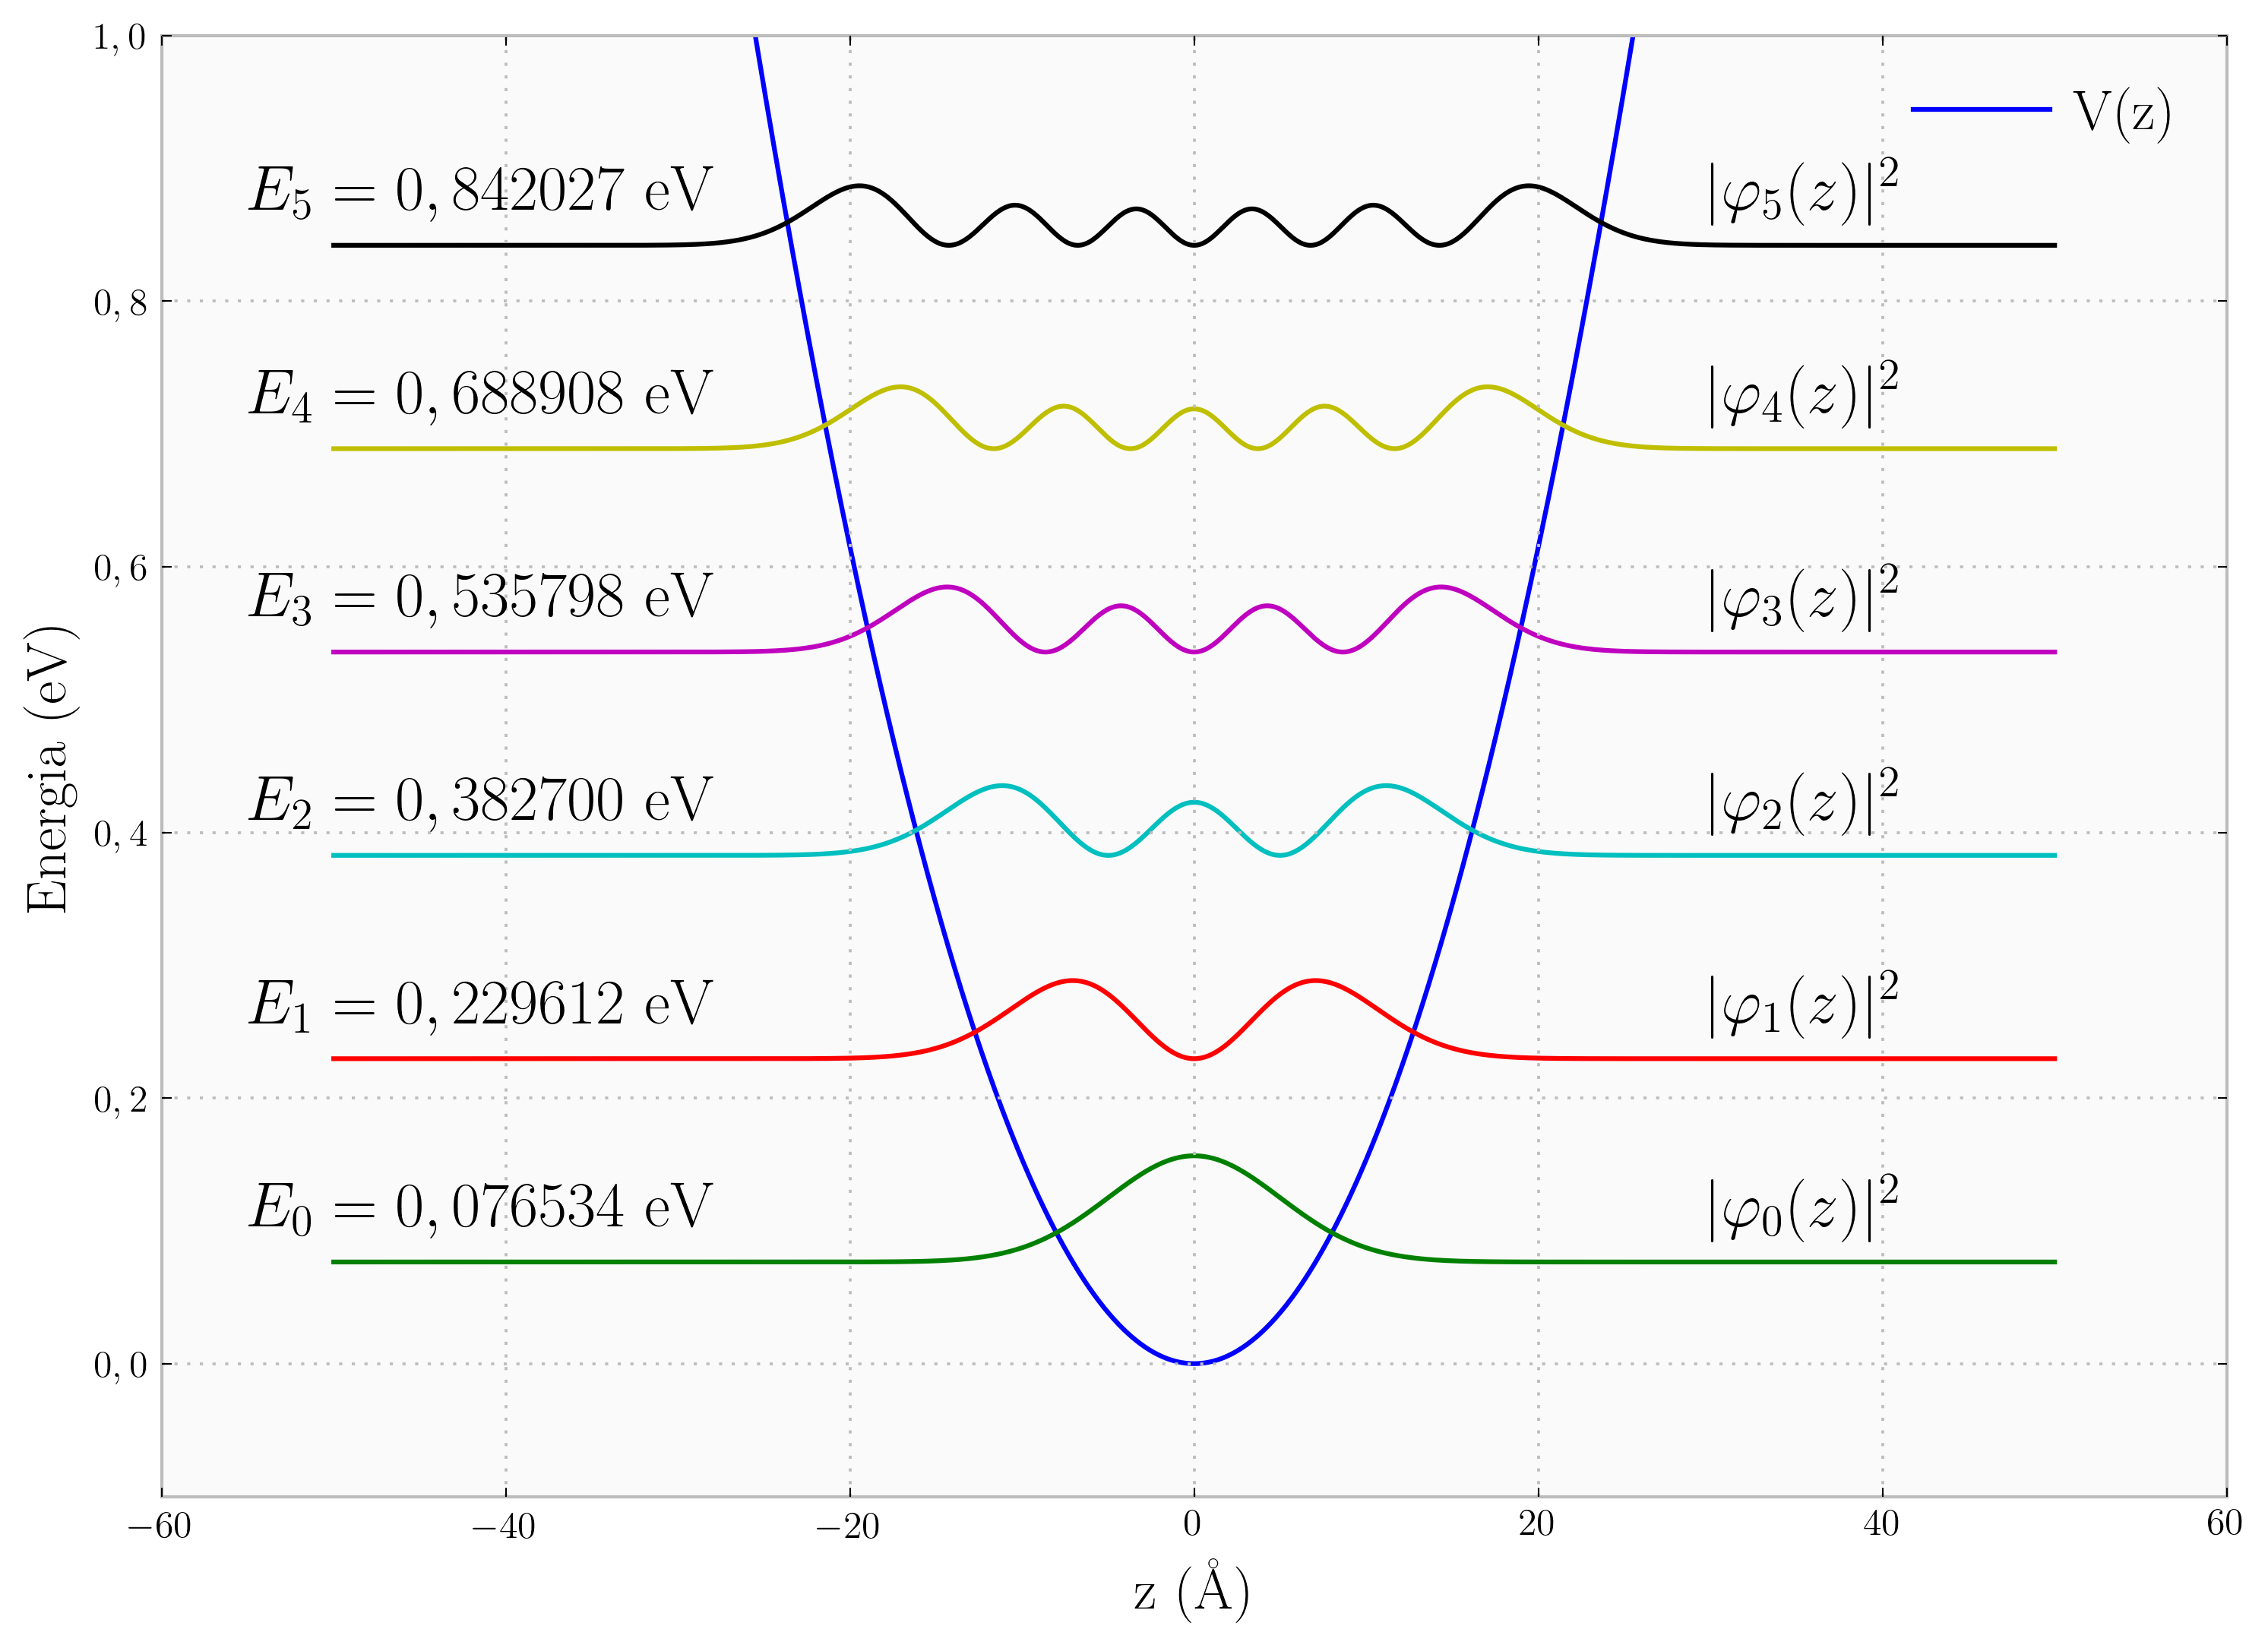

In [23]:
z_si, z_au, v_ev, v_si, v_au = potencial_au(8.1e-6, L=100.0, N=1024)
z_ang = z_au * au2ang
eigenstates_au = res[900000]['eigenstates_au']
eigenvalues_ev = res[900000]['eigenvalues_ev']
eigenstates_ang = eigenstates_au.copy()
for i, es in enumerate(eigenstates_au):
    norm_ang = np.sqrt(simps(es*es.conj(), z_ang))
    eigenstates_ang[i] = np.abs(eigenstates_au[i]/norm_ang)**2+eigenvalues_ev[i]

fig, ax = plt.subplots()
ax.set_xlabel(r'z (\AA)')
ax.set_ylabel(r'Energia (eV)')

plt.ylim(-0.1, 1.0)
ax.plot(z_ang, v_ev, label='V(z)')
for i, es in enumerate(eigenstates_ang):
    ax.plot(z_ang, es)#, label=r'$\varphi_{} (z)$'.format(i))
    evlabel = (r'$E_{} = {:.6f}$ eV'.format(i, eigenvalues_ev[i]))
    evlabel = evlabel.replace('.', ',')
    ax.text(-55, eigenvalues_ev[i]+0.02, evlabel)
    ax.text(30, eigenvalues_ev[i]+0.02, r'$|\varphi_{} (z)|^2$'.format(i))
plt.legend()
plt.savefig('figuras/oscilador_harmonico_autovetores_2.png') 